# **CIS 5450 Final Project: Bitcoin Ransomware Transactions**
Mario Valek, Siddhant Vashisht, Edwin Mui

# Introduction
For our CIS 5450 final project, we wanted to gain a better understanding of the behaviors of Bitcoin transactions. Although these transactions are all anonymous, we predicted that there could be some patterns that determine whether a particular address was considered ransomware or not. To achieve this, we utilized the BitcoinHeist Ransomware Dataset taken from Kaggle. By utilizing certain elements of a transaction, like loops, length, count, and neighbors, we wanted to classify whether or not the transaction in question was considered ransomware.

# Data Loading & Preprocessing


## Importing Libraries

In the following code block, we import all libraries that will be utilized in this CoLab. This includes pandas, polars, sklearn, and other helpful libraries.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import polars as pl
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Dataset Download
The bitcoin ransomware dataset was taken from Kaggle. To import this dataset correctly, there must be a `kaggle.json` in your root Drive Folder. We very simply download the zipped file and unzip to the CoLab directory.

In [ ]:
#get dataset from kaggle using user API from drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!!kaggle datasets download sapere0/bitcoinheist-ransomware-dataset

Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists


['Dataset URL: https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset',
 'License(s): CC0-1.0',
 'bitcoinheist-ransomware-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip /content/bitcoinheist-ransomware-dataset.zip

Archive:  /content/bitcoinheist-ransomware-dataset.zip
replace BitcoinHeistData.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BitcoinHeistData.csv    


## Data-Preprocessing

### Load CSV into Pandas Dataframe

In [ ]:
#csv to pd
raw_df = pd.read_csv('/content/BitcoinHeistData.csv')
raw_df

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,1.000500e+08,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,1.000000e+08,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,2.000000e+08,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,7.120000e+07,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,2.000000e+08,princetonLocky
...,...,...,...,...,...,...,...,...,...,...
2916692,12D3trgho1vJ4mGtWBRPyHdMJK96TRYSry,2018,330,0,0.111111,1,0,1,1.255809e+09,white
2916693,1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2,2018,330,0,1.000000,1,0,1,4.409699e+07,white
2916694,1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw,2018,330,2,12.000000,6,6,35,2.398267e+09,white
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,1.780427e+08,white


### Drop NaN Rows
We attempt to drop NaN rows here. However, it looks like there are none to begin with.

In [ ]:
#Data Show NaN rows
nan_rows = raw_df[raw_df.isna().any(axis=1)]
nan_rows
filtered_df = raw_df.dropna(axis='columns')

### Formatting Dates into MM/DD/YYYY
Here, we notice that the dates of the transactions are formatted in a `year` and `day` column. To improve readability and interpretation, we create an additional column, `date`, that formats the data accordingly.

However, at this stage of the data pre-processing, we realize that with nearly 3 million rows, so we begin integrating polars as well to analyze time performance improvement.

In [ ]:
%%time
#Create mm/dd/yyyy column
filtered_df['date'] = pd.to_datetime(filtered_df['year'] * 1000 + filtered_df['day'], format='%Y%j')

filtered_df

CPU times: user 10.4 s, sys: 182 ms, total: 10.6 s
Wall time: 11.6 s


,address,year,day,length,weight,count,looped,neighbors,income,label,date
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,1.000500e+08,princetonCerber,2017-01-11
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,1.000000e+08,princetonLocky,2016-05-11
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,2.000000e+08,princetonCerber,2016-09-02
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,7.120000e+07,princetonCerber,2016-11-17
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,2.000000e+08,princetonLocky,2016-08-25
...,...,...,...,...,...,...,...,...,...,...,...
2916692,12D3trgho1vJ4mGtWBRPyHdMJK96TRYSry,2018,330,0,0.111111,1,0,1,1.255809e+09,white,2018-11-26
2916693,1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2,2018,330,0,1.000000,1,0,1,4.409699e+07,white,2018-11-26
2916694,1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw,2018,330,2,12.000000,6,6,35,2.398267e+09,white,2018-11-26
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,1.780427e+08,white,2018-11-26


In [ ]:
%%time
filtered_pl = pl.from_pandas(filtered_df)
filtered_pl = filtered_pl.with_columns(
    pl.from_pandas(pd.to_datetime(filtered_pl['year'] * 1000 + filtered_pl['day'], format='%Y%j')).alias('date'),
    pl.col('date').dt.strftime('%m/%d/%Y').alias('mm_dd_yyyy')
)

CPU times: user 12.4 s, sys: 448 ms, total: 12.8 s
Wall time: 14.5 s


With the transition to polars, it seems that the time cost was cut nearly in half (7 s → 14 s)

### Getting Unique Ransomware Labels
We wanted to get a list of all unique ransomware types. Note that 'white' implies that there was no ransomware involved.

In [ ]:
#Get unique labels
unique_labels = filtered_df['label'].unique()
print(unique_labels)

['princetonCerber' 'princetonLocky' 'montrealCryptoLocker'
 'montrealCryptXXX' 'paduaCryptoWall' 'montrealWannaCry'
 'montrealDMALockerv3' 'montrealCryptoTorLocker2015' 'montrealSamSam'
 'montrealFlyper' 'montrealNoobCrypt' 'montrealDMALocker' 'montrealGlobe'
 'montrealEDA2' 'paduaKeRanger' 'montrealVenusLocker' 'montrealXTPLocker'
 'paduaJigsaw' 'montrealGlobev3' 'montrealJigSaw' 'montrealXLockerv5.0'
 'montrealXLocker' 'montrealRazy' 'montrealCryptConsole'
 'montrealGlobeImposter' 'montrealSam' 'montrealComradeCircle'
 'montrealAPT' 'white']


Then aggregate them into their own dataframes.

In [ ]:
#Seperate into dfs by label | {label}_df
for cat in unique_labels:
    globals()[f"{cat}_df"] = filtered_df[filtered_df['label'] == cat]

# Visualizations/EDAs

## Min, Max, Mean of Each Transaction Feature

We use polars and pandas to check the time difference of calculating min, max, and mean of each transaction feature. We realize that this includes outliers and such, so we attempt to prune them in later visualizations. Interestingly enough, polars seems to be slower than pandas in this instance.

In [ ]:
%%time
transaction_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
summary_stats_pd = filtered_df[transaction_features].agg(['min', 'max', 'mean'])
print("Statistics:\n", summary_stats_pd)

Statistics:
           length        weight         count        looped     neighbors  \
min     0.000000  3.606469e-94      1.000000      0.000000      1.000000   
max   144.000000  1.943749e+03  14497.000000  14496.000000  12920.000000   
mean   45.008593  5.455192e-01    721.644643    238.506699      2.206516   

            income  
min   3.000000e+07  
max   4.996440e+13  
mean  4.464889e+09  
CPU times: user 134 ms, sys: 58.2 ms, total: 192 ms
Wall time: 191 ms


In [ ]:
%%time
transaction_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
summary_stats_pl = filtered_pl.select(transaction_features).describe()
print("Statistics:\n", summary_stats_pl)

Polars Summary Statistics:
 shape: (9, 7)
┌────────────┬────────────┬─────────────┬─────────────┬────────────┬────────────┬──────────────┐
│ statistic  ┆ length     ┆ weight      ┆ count       ┆ looped     ┆ neighbors  ┆ income       │
│ ---        ┆ ---        ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ---          │
│ str        ┆ f64        ┆ f64         ┆ f64         ┆ f64        ┆ f64        ┆ f64          │
╞════════════╪════════════╪═════════════╪═════════════╪════════════╪════════════╪══════════════╡
│ count      ┆ 2.916697e6 ┆ 2.916697e6  ┆ 2.916697e6  ┆ 2.916697e6 ┆ 2.916697e6 ┆ 2.916697e6   │
│ null_count ┆ 0.0        ┆ 0.0         ┆ 0.0         ┆ 0.0        ┆ 0.0        ┆ 0.0          │
│ mean       ┆ 45.008593  ┆ 0.545519    ┆ 721.644643  ┆ 238.506699 ┆ 2.206516   ┆ 4.4649e9     │
│ std        ┆ 58.982362  ┆ 3.674255    ┆ 1689.675794 ┆ 966.321686 ┆ 17.918765  ┆ 1.6269e11    │
│ min        ┆ 0.0        ┆ 3.6065e-94  ┆ 1.0         ┆ 0.0        ┆ 1.0        ┆ 3e7

##Number of Instances Per Unique Label

By using both polars and pandas, we wanted to analyze the time difference given our large dataset. Additionally, we plotted the counts in a bar chart, for better visualization of the most commonly occuring types of labels. `white` seems to be the most commonly occuring, and since it means no ransomware involved, we choose to omit `white` occasionally in future visualizations.

In [ ]:
%%time
label_counts_pd = filtered_df['label'].value_counts()
print("Pandas Label Counts:\n", label_counts_pd)

Pandas Label Counts:
 label
white                          2875284
paduaCryptoWall                  12390
montrealCryptoLocker              9315
princetonCerber                   9223
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        13
montrealAPT                         11
paduaKeRanger                       10
montrealFlyper                       9
montrealXTPLocker                    8
montrealVenusLocker                  7
montrealCryptConsole                 7
montrealXLockerv5.0                  7
montrealEDA2                         6
montrealJigSaw                      

In [ ]:
%%time
label_counts_pl = filtered_pl['label'].value_counts()
print("Label Counts:\n", label_counts_pl)

Label Counts:
 shape: (29, 2)
┌───────────────────────┬───────┐
│ label                 ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ montrealAPT           ┆ 11    │
│ montrealXLockerv5.0   ┆ 7     │
│ paduaJigsaw           ┆ 2     │
│ montrealComradeCircle ┆ 1     │
│ montrealGlobev3       ┆ 34    │
│ …                     ┆ …     │
│ montrealDMALocker     ┆ 251   │
│ montrealSamSam        ┆ 62    │
│ montrealJigSaw        ┆ 4     │
│ princetonCerber       ┆ 9223  │
│ montrealCryptXXX      ┆ 2419  │
└───────────────────────┴───────┘
CPU times: user 80.5 ms, sys: 57.3 ms, total: 138 ms
Wall time: 137 ms


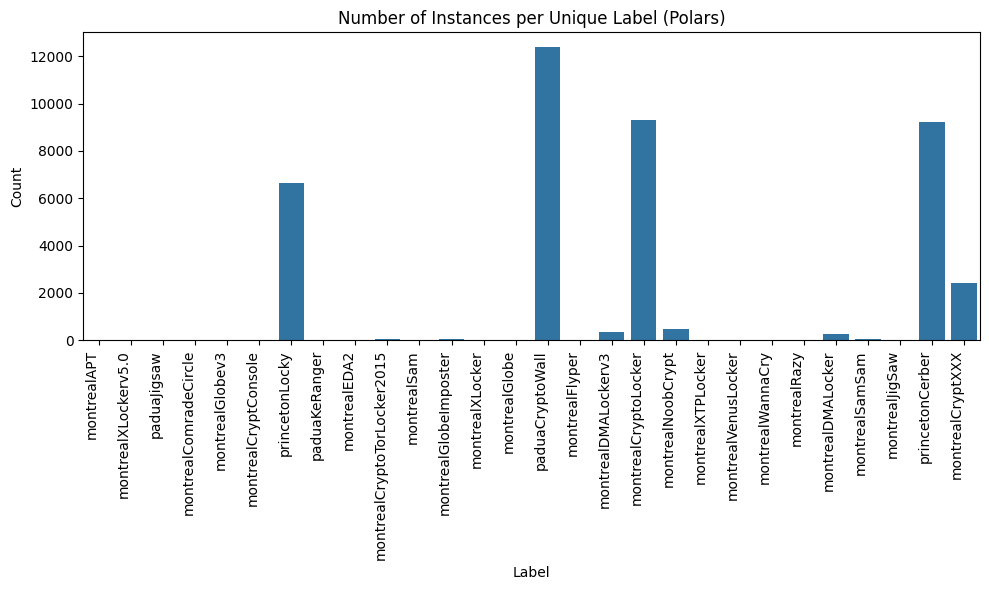

In [ ]:
label_counts_pd_pl = label_counts_pl.to_pandas()

#Exclude white
label_counts_pd_pl = label_counts_pd_pl[label_counts_pd_pl['label'] != 'white']

# Visualize label distribution (bar chart)
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts_pd_pl['label'], y=label_counts_pd_pl['count'])
plt.title('Number of Instances per Unique Label (Polars)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

## Label Distribution
In our label distribution analysis (excluding the "white" or non-ransomware class), we generated a pie chart to visualize the proportion of each ransomware family present in the dataset. This visualization reveals that a few ransomware families—such as **locky**, **cerber**, and **cryptolocker**—dominate the malicious address space, together accounting for the majority of labeled ransomware activity. This imbalance highlights the importance of focusing our modeling efforts on these high-frequency labels while also considering techniques like stratified sampling or class weighting to ensure rare classes are not ignored. The pie chart was chosen because it conveys the relative prevalence of each ransomware label, helping us determine how to best handle both targeted classification and anomaly detection.

**Top Ransomware Variants:**

paduaCryptoWall (42.48%): A prevalent ransomware strain that encrypts files and demands payment for decryption
montrealCryptoLocker (31.94%): Major ransomware variant that locks access to files until payment
princetonCerber (31.62%): Sophisticated ransomware that encrypts files and demands ransom in cryptocurrency
princetonLocky (22.71%): Ransomware that renames and encrypts files with a .locky extension

**Other variants:**

montrealCryptXXX (8.29%): Ransomware that targets Windows systems with strong encryption
montrealNoobCrypt (1.66%): Less sophisticated ransomware likely targeted at inexperienced cybercriminals
montrealDMALockerv3 (1.21%): Third iteration of the DMA Locker ransomware family


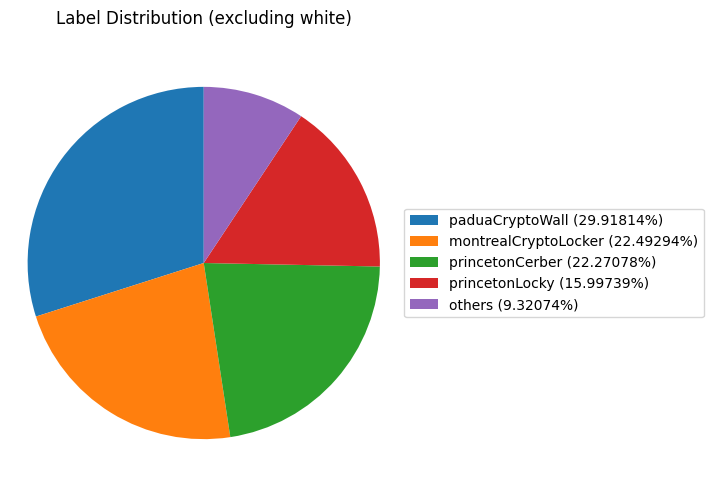

Label Counts:
paduaCryptoWall: 12390 (29.9%)
montrealCryptoLocker: 9315 (22.5%)
princetonCerber: 9223 (22.3%)
princetonLocky: 6625 (16.0%)
others: 3860 (9.3%)


In [ ]:
# #Pie Chart of Label Distribution
# label_counts = filtered_df['label'].value_counts()

# label_counts = label_counts.drop('white', errors='ignore')

# plt.figure(figsize=(5, 10))
# plt.pie(label_counts, labels=None, autopct=None, startangle=90)
# plt.title('Label Distribution (excluding white)')
# plt.axis('equal')
# labels = [f'{label} ({count / filtered_df["label"].count() * 100:.5f}%)'
#           for label, count in label_counts.items()]
# plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# print("Label Counts:")
# for label, count in label_counts.items():
#   percentage = (count / filtered_df['label'].count()) * 100
#   print(f"{label}: {count} ({percentage:.1f}%)")

# Pie Chart of Label Distribution
label_counts = filtered_df['label'].value_counts()
label_counts = label_counts.drop('white', errors='ignore')

# Group labels below 10% as 'others'
threshold = 10.0  # Percentage threshold
others_mask = (label_counts / label_counts.sum() * 100) < threshold
others_count = label_counts[others_mask].sum()
label_counts = label_counts[~others_mask]
if others_count > 0:
    label_counts['others'] = others_count

plt.figure(figsize=(5, 6))
plt.pie(label_counts, labels=None, autopct=None, startangle=90)
plt.title('Label Distribution (excluding white)')
plt.axis('equal')

# Create labels with percentages
labels = [f'{label} ({count / label_counts.sum() * 100:.5f}%)'
          for label, count in label_counts.items()]
plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("Label Counts:")
for label, count in label_counts.items():
    percentage = (count / label_counts.sum()) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")

## CDF Plots of Transaction Elements

**Cumulative Distribution of Length**

The length attribute demonstrates a multi-phase distribution pattern with approximately 42% of transactions having lengths below 10, followed by a more gradual increase to about 70% by length 40. This suggests many transactions have relatively short lengths, but there's a significant long tail with a sharp jump near length 150, indicating potential outliers or a specific transaction type with unusually long lengths that may require special handling in analysis.
The weight distribution shows an extremely steep curve with nearly 100% of transactions having weights below 100, suggesting this attribute is heavily concentrated at low values. This highly skewed distribution indicates that while the range extends to 2000, almost all transaction weights fall within a narrow band, making outlier transactions with higher weights particularly notable for forensic analysis.

**Cumulative Distribution of Count**

The count attribute reveals a pattern with about 57% of transactions having very low counts, followed by a steady increase to 90% by count 3000, and gradually approaching 100% around count 8000. This suggests most transactions involve a limited number of operations, with a small percentage containing significantly higher counts that may represent complex transaction patterns.

**Cumulative Distribution of Looped**

The looped variable, which indicates transactions referencing themselves or forming circular patterns, starts at a baseline of approximately 86% with zero loops. The gradual increase to 100% by value 8000 indicates that looped transactions are relatively uncommon but present in meaningful numbers, which could be significant for identifying specific transaction behaviors.

**Cumulative Distribution of Neighbors**

The neighbors attribute shows almost all transactions have very few neighbors, with an extremely steep curve similar to the weight distribution. This suggests most Bitcoin transactions in this ransomware dataset operate with limited connection to other transactions, with any transactions having high neighbor counts being extremely rare and potentially significant for further analysis.

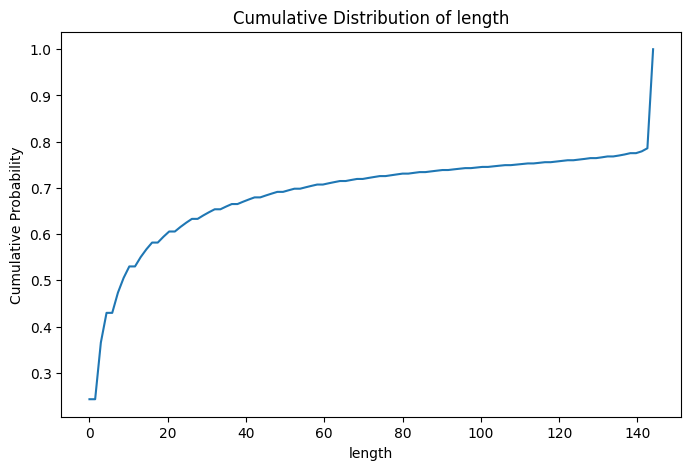

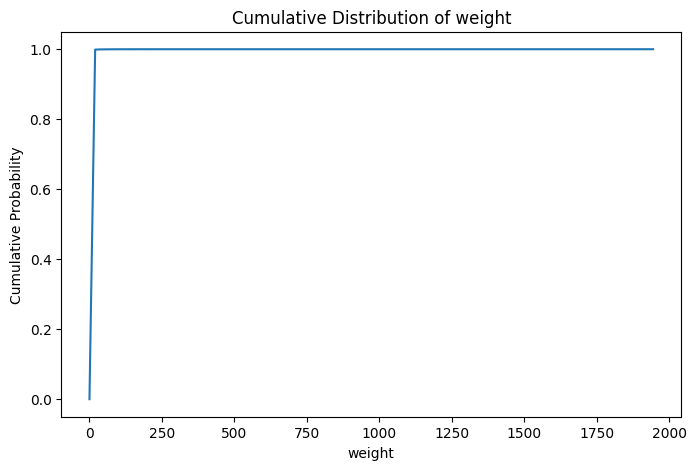

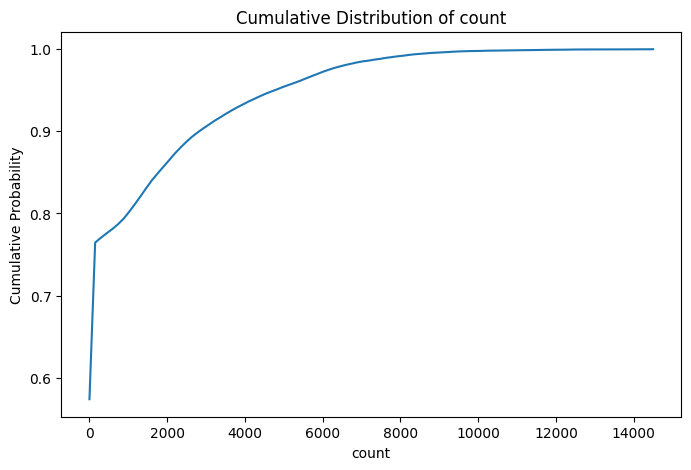

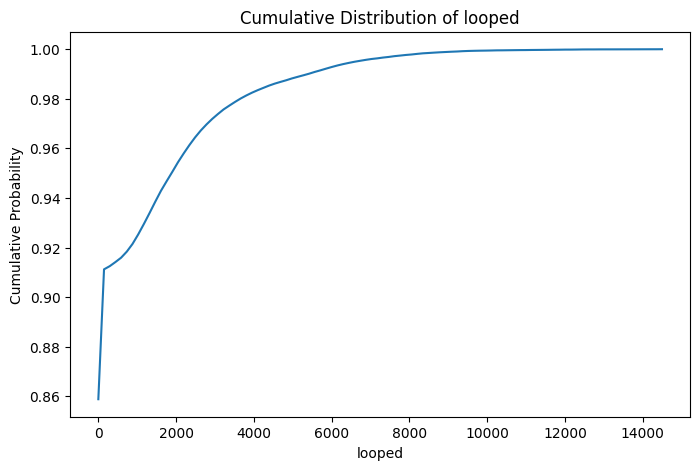

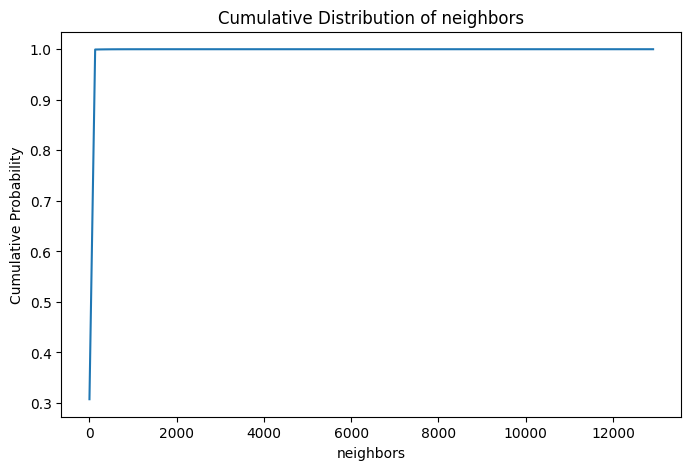

In [ ]:
#CDF Plots of multiple elements of the transaction to show outliers and variance
cols = ['length', 'weight', 'count', 'looped', 'neighbors']
for col in cols:
    plt.figure(figsize=(8, 5))
    ecdf = sm.distributions.ECDF(filtered_df[col])
    x = np.linspace(min(filtered_df[col]), max(filtered_df[col]), num=100)
    y = ecdf(x)
    plt.plot(x, y)
    plt.title(f'Cumulative Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Cumulative Probability')
    plt.show()

## Ransomware Occurences Over Time

The time series plot of ransomware occurrences from 2011 to 2018 reveals a the change of this cyber threat landscape. Beginning with minimal activity in 2011 (less than 500 occurrences), ransomware incidents show a steady increase through 2012 before jumping significantly in 2013 to approximately 7,500 cases. This upward trajectory continued to a local peak of about 10,300 occurrences in 2014, followed by a significant decline to around 3,800 incidents in 2015.
There is a dramatic spike in 2016, when ransomware occurrences reached their maximum of approximately 15,500 cases—nearly a 400% increase from the previous year. This jump could correspond to the emergence of major ransomware families or campaigns during this period. Following this peak, the trend reversed with occurrences dropping to about 3,500 in 2017 and continuing to decline toward near-zero by 2018 (this could be because of the lack of data onwards).
This bell-shaped pattern with two distinct peaks (2014 and 2016) suggests a cyclical nature to ransomware campaigns, potentially reflecting law enforcement crackdowns, evolving cybersecurity defenses, or shifts in attacker strategies. The dramatic decline after 2016 may indicate improved security measures, successful disruption of ransomware infrastructure, or threat actors transitioning to other more profitable attack vectors as the cryptocurrency ecosystem evolved.

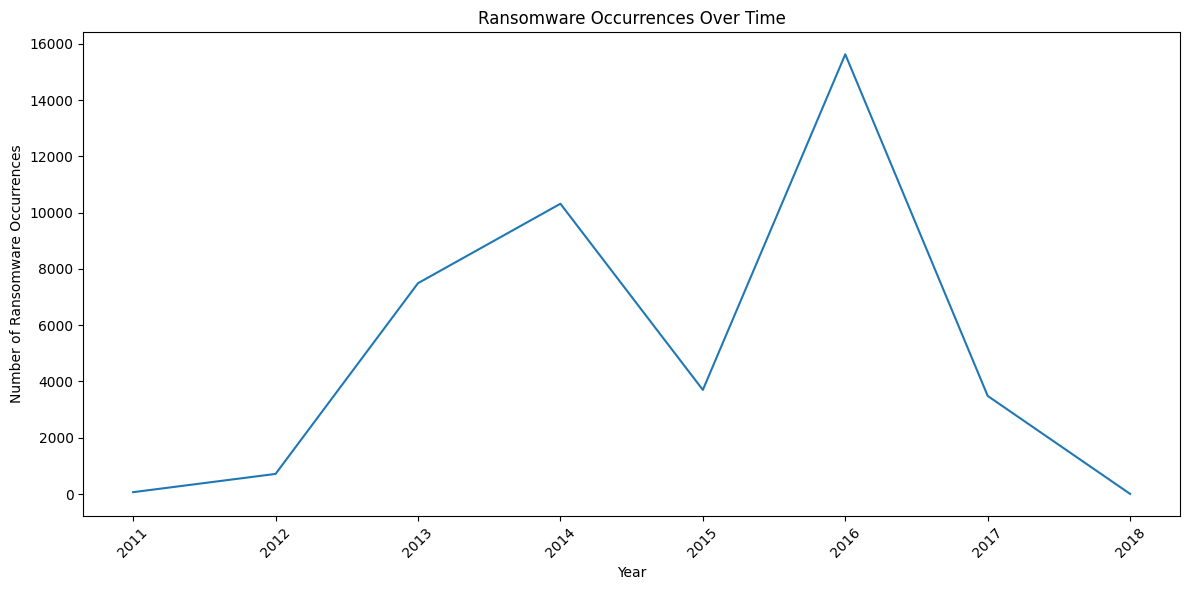

In [ ]:
#Line Chart of Ransomware Over Time
ransomware_df = filtered_df[filtered_df['label'] != 'white']
ransomware_counts = ransomware_df.groupby('year').size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
plt.plot(ransomware_counts['year'], ransomware_counts['counts'], marker=None, linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Ransomware Occurrences')
plt.title('Ransomware Occurrences Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Transaction Value by Label (Outliers hidden)

The log-scale boxplot without outliers is important when dealing with highly skewed transaction data. By using a logarithmic scale on the y-axis, we can visualize the full range of transaction values across all labels without smaller values being compressed to invisibility. Removing outliers from the visualization (while keeping them in the analysis) prevents extreme values from dominating the graph and obscuring meaningful patterns. This approach maintains the integrity of the data while making the distribution characteristics of each label visible and comparable, revealing median values, quartiles, and the overall spread that would otherwise be impossible to discern in the original linear-scale visualization.

The log-scale boxplot reveals significant variation in transaction values across different labels. "MontrealRansom" stands out dramatically with median values exceeding 10^10, approximately 10-100 times higher than most other categories. Several labels show substantial transaction ranges spanning multiple orders of magnitude, indicating high variability within categories. Labels like "montrealBankSam", "montrealDMALocker3", and "montrealSam" display higher median values (around 10^9), while labels such as "montrealFlyper" and "montrealEDA2" process considerably smaller transactions (below 10^8). The log transformation successfully exposes these patterns that were obscured in the original visualization, while hiding outliers prevents extreme values from compressing the visualization further. This distribution suggests distinct economic models or targeting strategies across different labels, with some consistently targeting higher-value transactions.

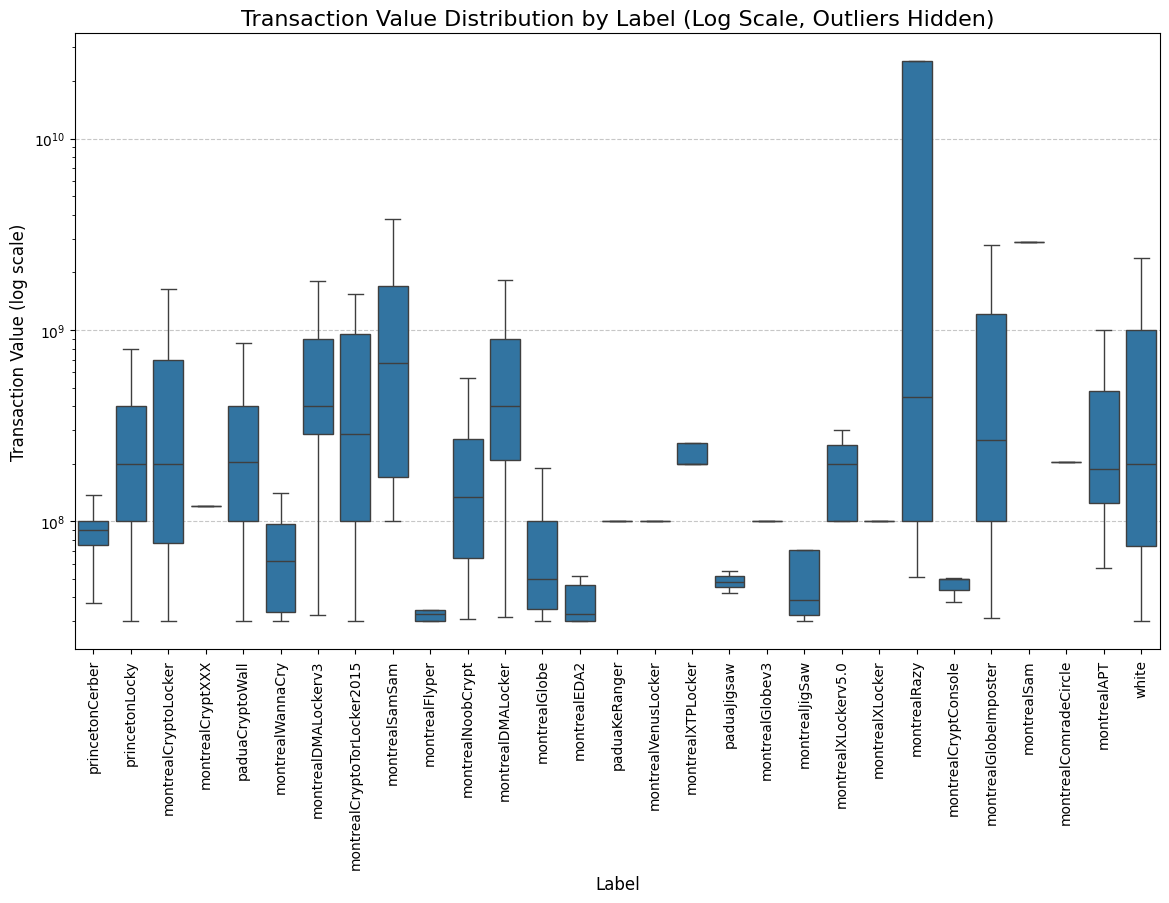

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='label', y='income', data=filtered_df, showfliers=False)
plt.yscale('log')
plt.title('Transaction Value Distribution by Label (Log Scale, Outliers Hidden)', fontsize=16)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Transaction Value (log scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

## Top 5 Labels by Median Transaction Value

The bar chart of top 5 labels by median transaction value provides focused insight into which categories consistently process the highest transaction amounts. Unlike means, which can be heavily skewed by outliers, median values represent the typical transaction size for each label. By isolating just the top performers, this visualization cuts through the noise of numerous categories and highlights the most economically significant labels. This information is particularly valuable for prioritization, resource allocation, and identifying key business segments that drive the highest typical transaction values.

This bar chart clearly identifies the dominant transaction processors by typical value. "MontrealRansom" towers above all others with a median transaction value of nearly 3×10^9, approximately four times higher than the second-ranked "montrealSam" at around 7×10^8. The remaining top performers—"montrealRazy", "montrealDMALocker", and "montrealDMALocker3"—show similar median values around 4×10^8, suggesting they might represent related operations or target similar victim profiles. The steep drop-off between the first and second positions highlights "MontrealRansom" as an exceptional case, potentially indicating a specialized operation targeting exclusively high-value transactions or representing a different economic model than its counterparts.

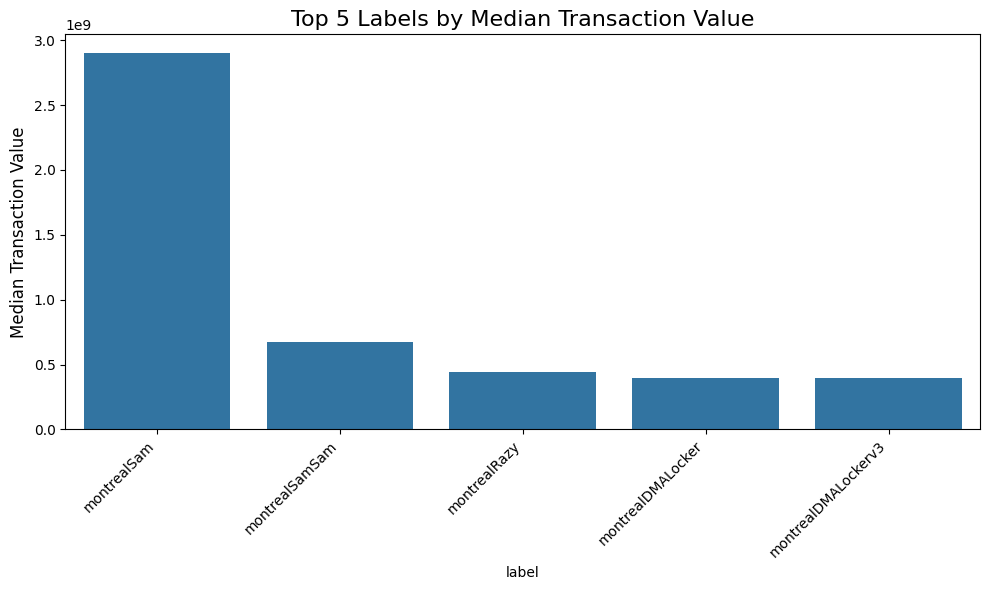

In [ ]:
plt.figure(figsize=(10, 6))
median_by_label = filtered_df.groupby('label')['income'].median().sort_values(ascending=False).head(5)
sns.barplot(x=median_by_label.index, y=median_by_label.values)
plt.title('Top 5 Labels by Median Transaction Value', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Median Transaction Value', fontsize=12)
plt.tight_layout()


##Transaction Length for Ransomware vs. White Transactions

This histogram compares the distribution of transaction lengths for ransomware transactions versus legitimate ('white') transactions. By overlaying the histograms, it can be determined if there are noticeable differences in the length distributions between the two groups. If ransomware transactions tend to have different lengths than normal transactions, this feature could be a useful indicator for classification.

The histogram comparing transaction lengths between "White" and "Ransomware" categories reveals distinct behavioral patterns. The "White" transactions show a bimodal distribution with high frequency peaks at very short lengths (0-5) and again at approximately length 140, suggesting standardized transaction formats or protocols at these specific lengths. In contrast, "Ransomware" transactions appear primarily concentrated at the lowest length values, with much smaller representation throughout the distribution. This suggests ransomware operations predominantly utilize shorter transaction formats, possibly for efficiency or to minimize detection. The drastically higher volume of "White" transactions (note the y-axis exceeding 600,000 instances) indicates these represent the vast majority of network activity, while ransomware transactions constitute a relatively minor portion of the overall transaction count.

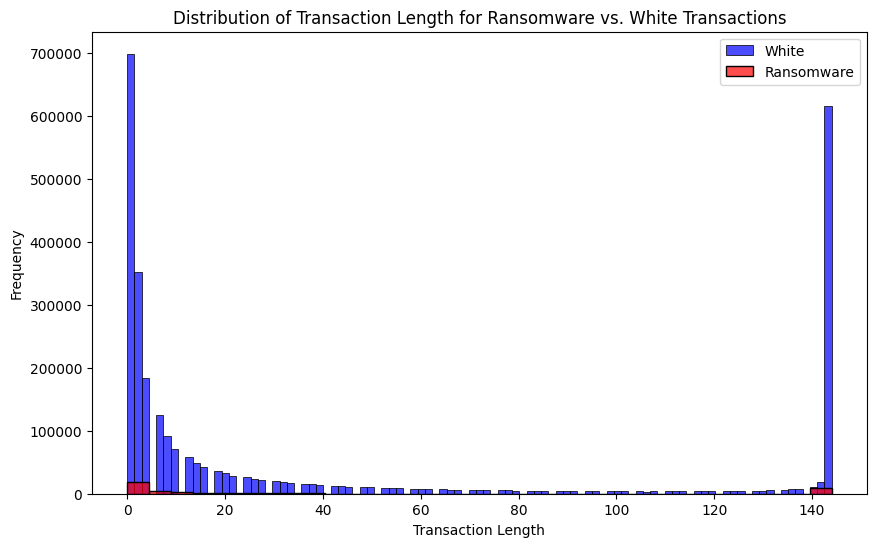

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df[filtered_df['label'] == 'white']['length'], label='White', color='blue', alpha=0.7)
sns.histplot(filtered_df[filtered_df['label'] != 'white']['length'], label='Ransomware', color='red', alpha=0.7)
plt.title('Distribution of Transaction Length for Ransomware vs. White Transactions')
plt.xlabel('Transaction Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Correlation Heatmap of Transaction Features

A correlation heatmap helps understand the relationships between different transaction features. It shows how strongly features like length, weight, count, looped, neighbors, and income are correlated with each other. This can help identify potential multicollinearity (high correlation between features), which might impact model performance. It can also highlight important feature interactions and guide feature selection for modeling.

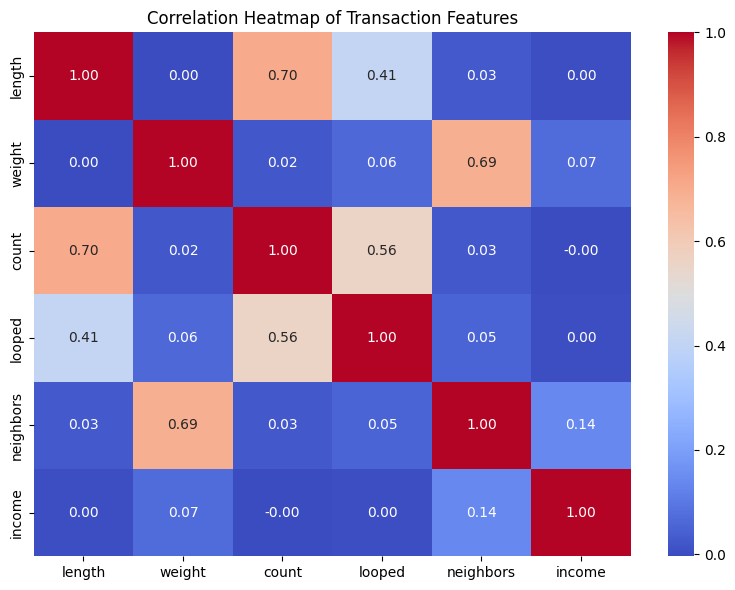

In [ ]:
features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
correlation_matrix = filtered_df[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Transaction Features')
plt.tight_layout()
plt.show()

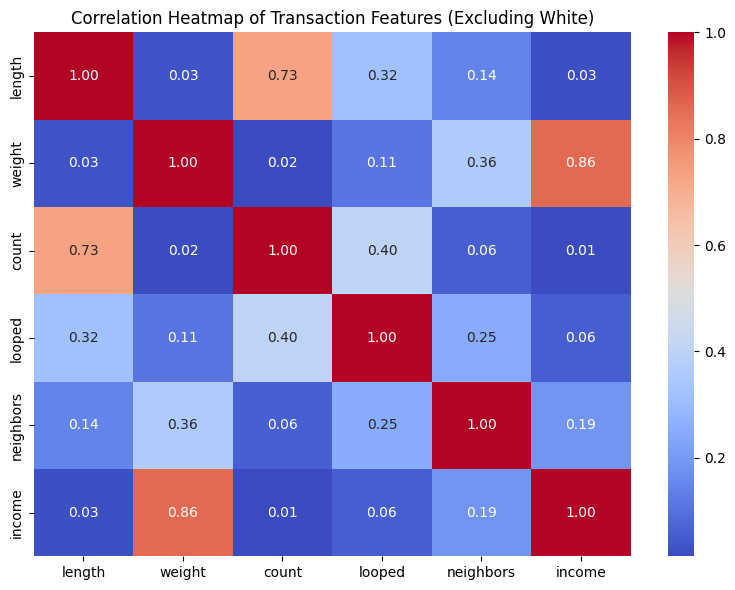

In [ ]:
#Exclude white
filtered_df_no_white = filtered_df[filtered_df['label'] != 'white']

features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']

correlation_matrix = filtered_df_no_white[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Transaction Features (Excluding White)')
plt.tight_layout()
plt.show()

#Feature Engineering


## Column Type Standarization

In this preprocessing step, we create a copy of the filtered dataset for feature engineering. Since a categorical `label` column is present, it is encoded into numerical format using `LabelEncoder` to make it suitable for machine learning models. We then extract only the numeric features (e.g., balances, transaction counts), excluding non-numeric identifiers like `address`, which do not contribute to predictive modeling. This ensures that the input data is strongly-typed, relevant, and machine-readable.

In [ ]:
feature_df = filtered_df.copy()

if 'label' in feature_df.columns:
    label_encoder = LabelEncoder()
    feature_df['label_encoded'] = label_encoder.fit_transform(feature_df['label'])

# Select numeric features (excluding addresses)
features = feature_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop address column
if 'address' in feature_df.columns:
    df = feature_df.drop(columns=['address'])

In this section, we first standardize the selected numerical features using StandardScaler to ensure each feature contributes equally to the PCA by having zero mean and unit variance. We felt that this would be useful because of the high dimensionality of our data, with a number of elements into each transaction. Next, we apply PCA to reduce the dimensionality of the dataset to two principal components, which capture the most significant variance in the data. Finally, we construct a new DataFrame with these components, and if available, include the encoded labels for potential classification or visualization tasks. This process simplifies the dataset while preserving key patterns, aiding both interpretability and computational efficiency.

## Scaling and PCA

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA components
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
if 'label_encoded' in df.columns:
    df_pca['label'] = df['label_encoded']

## PCA Results

We visualize the results of PCA by plotting the first two principal components. Each data point is colored according to its encoded label using a colormap  for easy distinction between classes. This scatter plot helps us visually assess whether the dimensionality-reduced features separate well by label, which can reveal underlying structure, clusters, or separability in the dataset — useful insights for classification or anomaly detection tasks.

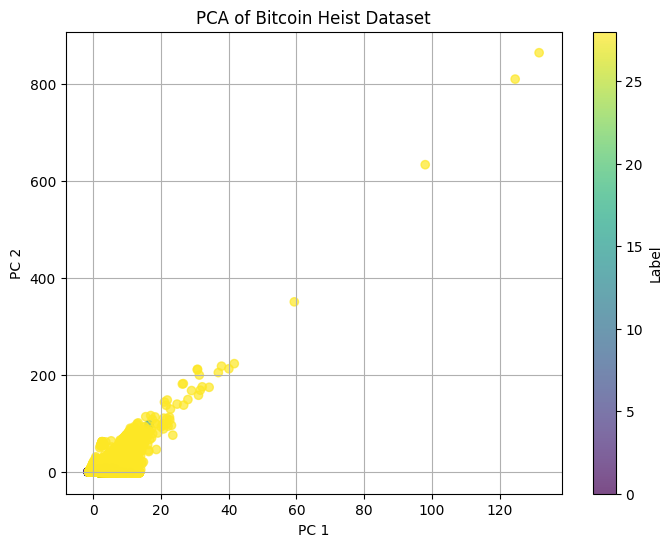

In [ ]:
# Visualize PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['label'], cmap='viridis', alpha=0.7)
plt.title('PCA of Bitcoin Heist Dataset')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(scatter, label='Label')
plt.grid(True)
plt.show()

#Models

We evaluate the model's performance by generating predictions on the test set and printing a classification report along with the accuracy score.

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

1. **Our baseline model achieves 66% overall accuracy**, with strong precision (99%) for normal transactions, but it misses 34% of them, while ransomware detection has high recall (76%) but suffers from a 97% false alarm rate when predicting ransomware.  
2. **We engineered new features** (e.g., `complexity_score`, `size_ratio`) to quantify transaction complexity and size anomalies, deliberately excluding network metrics to keep the model simple and interpretable.  
3. **We trained an XGBoost classifier** with class weighting to handle imbalance, prioritizing ransomware detection without overloading analysts with false alarms, and evaluated its performance on a held-out test set (40%).  

In [ ]:
"""
New version (lower performance accuracy)
Baseline model performance (overall accuracy is 66%):
  For Normal Transactions:
    - 99% Precision when the model says a transaction is normal
    - Misses 34% of normal transactions
  For Ransomware Transactions:
    - Catches 76% of ransomware
    - 97% are false alarms when it predicts ransomware,
"""
# "Complexity Score" = How long (length) AND repetitive (looped) a transaction is.
# Higher values mean the transaction is more complex.
filtered_df['complexity_score'] = filtered_df['length'] * filtered_df['looped']

# "Size Ratio" = Transaction weight divided by how many times it occurs (count).
# Helps identify unusually large or small transactions relative to their frequency.
filtered_df['size_ratio'] = filtered_df['weight'] / (filtered_df['count'] + 1)

# "Network Activity" = How many neighbors a transaction has multiplied by its count.
# Measures how much interaction this transaction has with others in the network.
filtered_df['network_activity'] = filtered_df['neighbors'] * filtered_df['count']

# The model will use these specific traits to decide if a transaction is suspicious:
# - Length, weight, count, looped, income, complexity_score, size_ratio
# We intentionally left out "neighbors" and "network_activity" to simplify the model.
features = ['length', 'weight', 'count', 'looped', 'income', 'complexity_score', 'size_ratio']

# X = All the features (traits) the model will learn from.
# y = The labels (0 = normal "white" transaction, 1 = ransomware).
X = filtered_df[features]
y = filtered_df['label'].apply(lambda x: 0 if x == 'white' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Configure the model (XGBoost)
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    max_depth=3,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)
# Train the model on the training data.
xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.66      0.79   1150278
           1       0.03      0.76      0.06     16401

    accuracy                           0.66   1166679
   macro avg       0.51      0.71      0.43   1166679
weighted avg       0.98      0.66      0.78   1166679

Accuracy: 0.66


**Dark Blue:** 757460 predicted non-ransomware and were not ransomware

**Light Blue:** 392818 predicted ransomware and were not ransomware

**White Left:** 3910 predicted non-ransomware and were ransomware

**White Right:** 12491 predicted ransomware and were ransomware

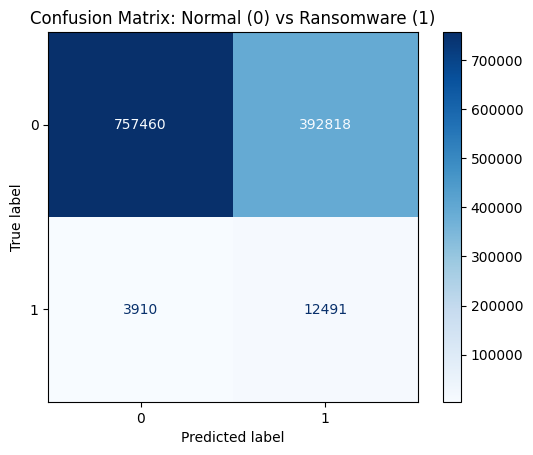

In [ ]:
# Create a confusion matrix showing the amount of predicted normal/ransomware labels and whether each prediction matches the true label or not for the model.
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Normal (0) vs Ransomware (1)')
plt.show()

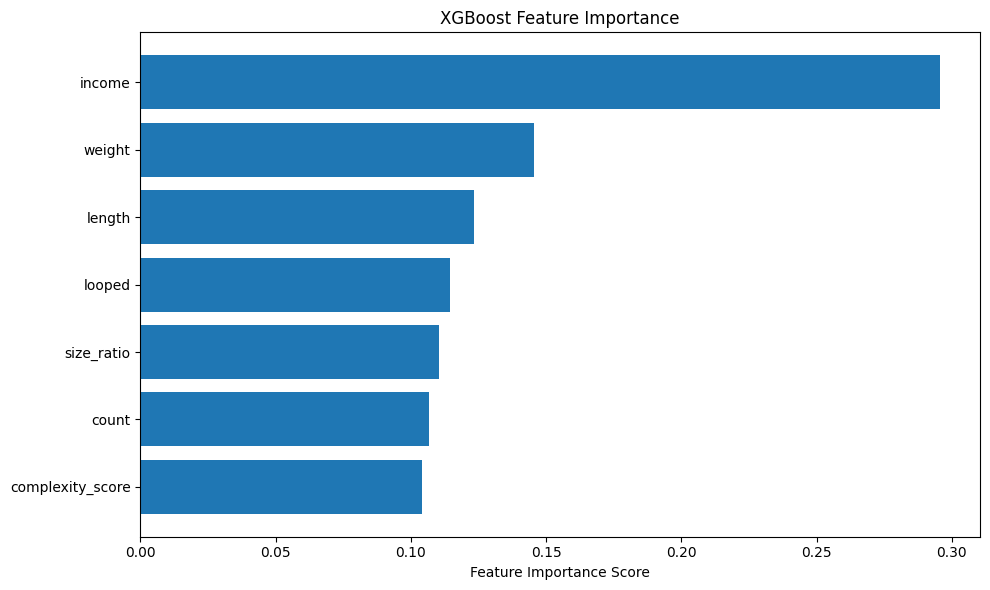


Feature Importance Scores:
length: 0.1233
weight: 0.1457
count: 0.1066
looped: 0.1143
income: 0.2956
complexity_score: 0.1040
size_ratio: 0.1104


In [ ]:
# Feature Importance Analysis
plt.figure(figsize=(10, 6))
xgb_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(xgb_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.barh(pos, xgb_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
for feature, importance in zip(features, xgb_importance):
    print(f"{feature}: {importance:.4f}")

#Hyperparameter Tuning & Data Balancing

The results of our baseline model and the EDA demonstrate a large data imbalance as a majority of the rows contained data which corrsponded to "white" payments (around 98% of the data). In order to fix this so that our models could accurately capture trends within the dataset and predict whether a payment is a ransomware payment or not, we incorporated resampling within our dataset to create a reasonable balance of ransomware to non-ransomware payments (ratio of 1:2). The total amount of rows post balancing totalled to over 120000, which is above the limit of 50000 needed for the project.

In [ ]:
# Resample the data by selecting 2 times the amount of rows corresponding to the ransomware payments for the number of white payments in the balanced_df
from sklearn.utils import resample

white = filtered_df[filtered_df['label'] == 'white']
ransomware = filtered_df[filtered_df['label'] != 'white']
print(white.head())
white_downsampled = resample(white,
                             replace=True,
                             n_samples=len(ransomware)*2, # Creates the 1:2 ratio. Changing the 2 here changes the ransomware:nonransomware ratio in the balanced_df
                             random_state=42)

balanced_df = pd.concat([white_downsampled, ransomware])
print(len(balanced_df))

                                  address  year  day  length  weight  count  \
41413  19snqSYnDSC4mDbv3pJuYgYqm5ctqwAxnm  2011    1       0     1.0      1   
41414  1FeGY25MSKtnwVNGrnbwLsecBpBYrMQ6Kx  2011    1       0     1.0      1   
41415  1A1nkBK7tfnVRtVbyiirEWRcayQtSTBCsW  2011    1       0     1.0      1   
41416  18wHa1PLzoU4ToemBZn2czZbVEbyZJ2gSi  2011    1       0     1.0      1   
41417  188sYyuK756uEsq5LTk9tiXyJHeEjxKT5c  2011    1       0     1.0      1   

       looped  neighbors        income  label       date  mm_dd_yyyy  \
41413       0          1  5.000000e+09  white 2011-01-01  01/01/2011   
41414       0          2  5.000000e+09  white 2011-01-01  01/01/2011   
41415       0          2  9.150000e+08  white 2011-01-01  01/01/2011   
41416       0          2  3.402500e+10  white 2011-01-01  01/01/2011   
41417       0          2  1.275100e+10  white 2011-01-01  01/01/2011   

       complexity_score  size_ratio  network_activity  
41413                 0         0.5 

In [ ]:
# Retraining baseline model with balanced dataframe (Around 124000 rows of of data)
balanced_df['complexity_score'] = balanced_df['length'] * balanced_df['looped']
balanced_df['size_ratio'] = balanced_df['weight'] / (balanced_df['count'] + 1)
balanced_df['network_activity'] = balanced_df['neighbors'] * balanced_df['count']

features = ['length', 'weight', 'count', 'looped', 'income', 'complexity_score', 'size_ratio']

X = balanced_df[features]
y = balanced_df['label'].apply(lambda x: 0 if x == 'white' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    max_depth=3,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      0.66      0.74     33173
           1       0.53      0.76      0.62     16523

    accuracy                           0.69     49696
   macro avg       0.69      0.71      0.68     49696
weighted avg       0.74      0.69      0.70     49696

Accuracy: 0.69


After training the XGBoost Model with the balanced dataset, which resulted in an increased accuracy of 69% from the original 66%, we incorporated hyperparameter tuning in order to finetune the model and increase the final accuracy of the linear regression model. We incorprorated RandomizedSearchCV from sklearn, which tested and selected optimal parameters from a given parameter distribution (best parameters listed below). The optimal parameters were then fitted to the XGBoost model, yielding an improved accuracy of 88% from the initial 69%

In [ ]:
# Use RandomizedSearchCV to finetune the hyperparameters of the model and then re-train the linreg model with the chosen hyperparameters
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

# Parameter distribution for RandomizedSearchCV
param_dist_fast = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

tuner_fast = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_fast,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting FAST hyperparameter tuning...")
tuner_fast.fit(X_train, y_train)

print(f"Best AUC (FAST tuning): {tuner_fast.best_score_:.4f}")
print("Best parameters (FAST tuning):", tuner_fast.best_params_)

# Evaluate
best_model_fast = tuner_fast.best_estimator_
evaluate_model(best_model_fast, X_test, y_test)


Starting FAST hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best AUC (FAST tuning): 0.9552
Best parameters (FAST tuning): {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 1, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     16692
           1       0.78      0.89      0.83      8156

    accuracy                           0.88     24848
   macro avg       0.86      0.88      0.87     24848
weighted avg       0.89      0.88      0.88     24848

Accuracy: 0.88


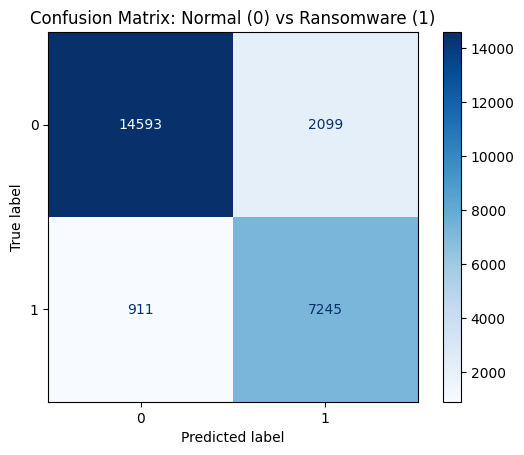

In [ ]:
# Create a confusion matrix showing the amount of predicted normal/ransomware labels and whether each prediction matches the true label or not for the model.
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_fast, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Normal (0) vs Ransomware (1)')
plt.show()

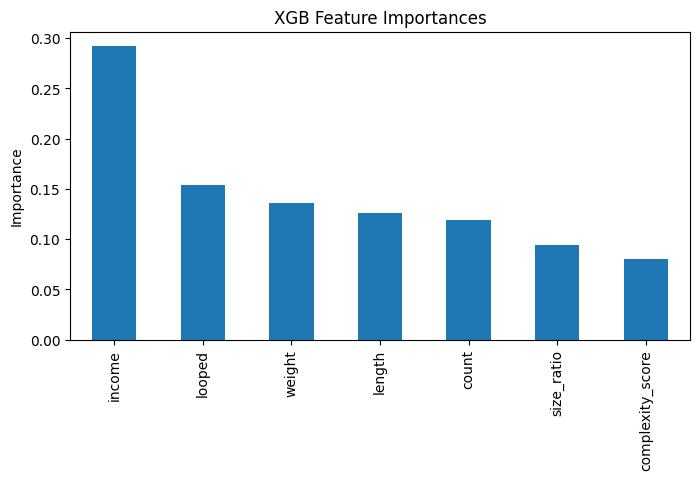


Feature Importance Scores:
length: 0.1261
weight: 0.1357
count: 0.1188
looped: 0.1539
income: 0.2920
complexity_score: 0.0797
size_ratio: 0.0938


In [ ]:
#Create another feature importances diagram with the finetuned retrained XGBoost model
fi = pd.Series(best_model_fast.feature_importances_, index=X.columns)
xgb_importance = best_model_fast.feature_importances_
fi.sort_values(ascending=False).plot.bar(figsize=(8,4))
plt.title('XGB Feature Importances')
plt.ylabel('Importance')
plt.show()

print("\nFeature Importance Scores:")
for feature, importance in zip(features, xgb_importance):
    print(f"{feature}: {importance:.4f}")

A final heatmap matrix shows a major improvement from the initial model, as the the initial model categorized more white as ransomware than it did ransomware. Since the final heatmap demonstrates that the model accurately predicted 88.83% of the ransomware payments and correclty predicted 87.42% of the non-ransomware payments from the testing data. This is a large improvement from the original data which was only able to predict 76.1% of the ransomware payments and 65.85% of the non-ransomware payments, incidicating that both the balanced dataframe and the finetuned hyperparameters improved both the model accuracy and major data imbakances reflected in the previous heatmap.

Additionally, another XGB feature importance chart with the revised hypertuned/resampled model demonstrates that income is still the most important feature for the XGBoost model, but the order of the other feature's importances are re-evaluted, indicating a shift in which secondary features are the most important for the finetunded model

#KNN Model

Along with the interperable linear regression XGBoost models that we built and finetuned, we implemented predictive models as well to see if we could more accurately classify bitcoin payments as ransomware or not based on our pre-processed data. Using the balanced dataset, we developed a KNN model using sklearn with n_neighbors of 5. We chose a KNN model as we wanted a supervised learning classification model that would work with the labels given for ransomware payments (0 indicating non-ransomware 1 indicating ransomware)

Test Accuracy: 0.8106

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     16692
           1       0.70      0.73      0.72      8156

    accuracy                           0.81     24848
   macro avg       0.78      0.79      0.79     24848
weighted avg       0.81      0.81      0.81     24848



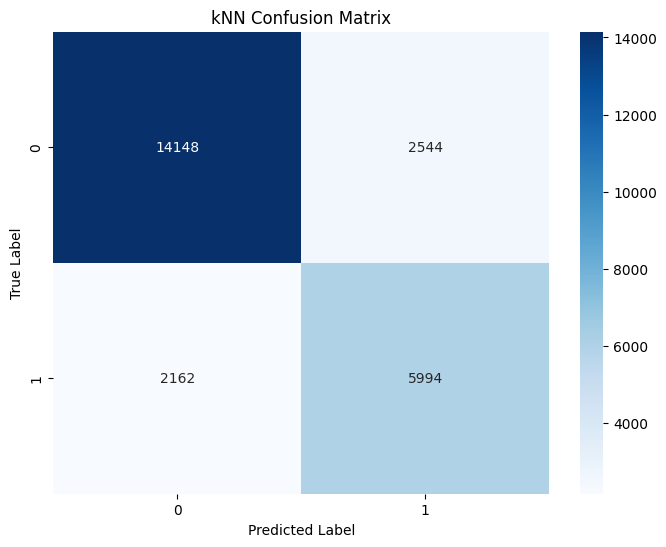

In [ ]:
# Create and train KNN Model. Acts as predictive model for classifying ransomware
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

#Create a label encoder and scaler to scale the x and y data accordingly to fit model parameters and drop unimportant features
le = LabelEncoder()
y = balanced_df['label'].apply(lambda x: 0 if x == 'white' else 1)
y = le.fit_transform(y)
X = balanced_df.drop(columns=['address','date','mm_dd_yyyy','label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

#Create the KNN model and fit it based on the train data.
knn = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           metric='minkowski',
                           p=2)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix showing the amount of predicted normal/ransomware labels and whether each prediction matches the true label or not for the model.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('kNN Confusion Matrix')
plt.show()

The KNN model resulted in a 81.06% accuracy, with a heatmap demonstrating a substantially higher accuracy in detecting non-ransomware payments than ransomware payments. This demonstrates that a supervised learning model such as a KNN has a fairly high accuracy at determining the status of a bitcoin payment, but the level of error within the results indicate that the n_neighbors may be too less and collect too much noise, demonstrating improvement in future model iterations.


#K-Means Clustering Model

Finally, we implemented an unsupervised learning model through the use of a K-Means Clustering model to see whether the data could be accurately classsified as ransomware vs non-ransomware without the use of labels. This would demonstrate whether the model could accurately deelop relationships from the features given in the dataset to accurately predict the status of the Bitcoin payments. A KMeans clusteirng model was implemented to divide the data into two separate clusters, with one meant to represent non-ransomware payments and the other meant to represent ransomware payments. Six features were used to train the model.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Select the features to be used for training clustering model (the quantitative numerical features in the dataset) from the balanced dataset
features_for_clustering = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']
X_kmeans = balanced_df[features_for_clustering]

# Scale down dataset to balance model results and make results easier to visualize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# Fit KMeans model with two clusters, one intending to represent non-ransomware payments and the other intending to represent ransomware payments
kmeans = KMeans(n_clusters=2, random_state=42)
balanced_df['cluster'] = kmeans.fit_predict(X_scaled)

# Perform PCA on the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

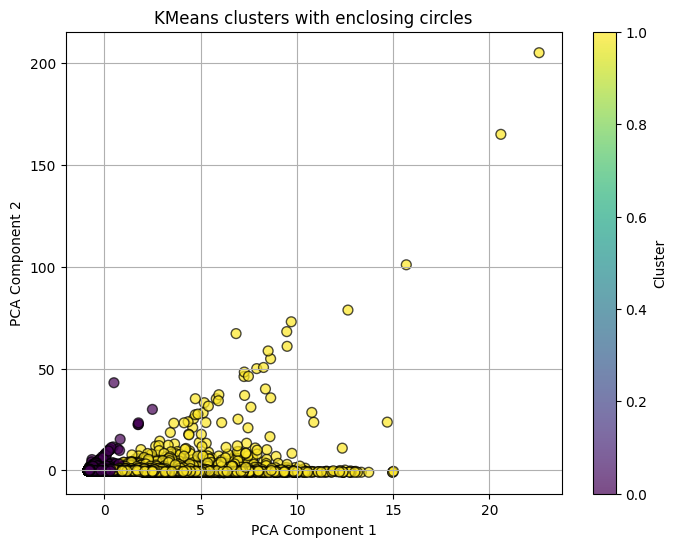

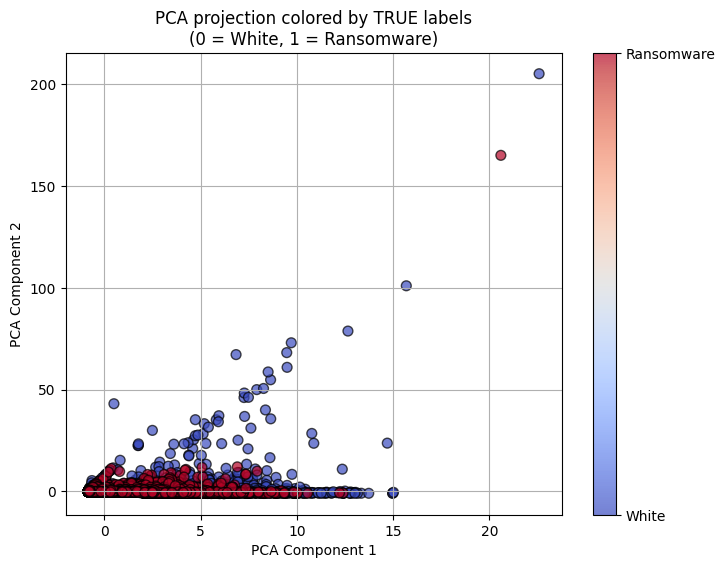

In [ ]:
from matplotlib.patches import Circle
orig_centers = kmeans.cluster_centers_

#Create a plot of the results of the KMeans clusteirng data with the PCA components as the axes
centers_pca = pca.transform(orig_centers)
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(
    X_pca[:,0], X_pca[:,1],
    c=balanced_df['cluster'],
    cmap='viridis',
    s=50, alpha=0.7,
    edgecolor='k'
)

ax.set_title('KMeans clusters with enclosing circles')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


# Plot the same PCA coords but colored by the TRUE ransomware label (1 = ransomware, 0 = non-ransomware)
y_true = (balanced_df['label'] != 'white').astype(int)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y_true,
    cmap='coolwarm',
    s=50, alpha=0.7,
    edgecolor='k'
)
plt.title('PCA projection colored by TRUE labels\n(0 = White, 1 = Ransomware)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
cbar = plt.colorbar(ticks=[0,1])
cbar.ax.set_yticklabels(['White','Ransomware'])
plt.grid(True)
plt.show()

Final distribution of the K-Means clustering demonstrate a clear difference between the two clusters, with a majority of the data points corresponding to cluster 0 residing on the left half of the graph and a majority of the data points corresponding to cluster 1 residing on the right. However, when compares to the actual distribution of ransomware/nonransomware payments in the second PCA graph, this demonstrates a large difference between the results, indicating that the clustering model was NOT accurately able to classify ransomware and non-ransomware. Thus, purely unsupervised learning models such as a KMeans Clustering model was NOT succesful in extracting trends between the features without relying on ransomware labels, indiciating the need for density or probability based unsupervised learning models to be able to classify and derive hidden relationships within this dataset.

We implemented conditioning on both predictive (kNN and K-Means) and interperative (XGBoost) Models by utilizing feature engineering and dataset balancing for the kNN and K-Means models to be able to understand hidden patterns within the features (to varying degrees as the kNN model performed much better than the K-Means) and be able to predict whether a Bitcoin payment was ransomware or not. We did the same for the XGBoost model along with feature importance screening to understand what features specifically contribute the most to determining whether a payment is ransomware or not, with income being the most important feature and the "looped" status of the payment being the secondary feature. Condtioning on both models allowed us to understand how to predict ransomware from nonransomware, as well as what factors contributed the most to identifying ransomware payments.

# Conclusion

## Challenges

A majority (almost 93%) of the data is 'white' (no ransomware), showing a heavy imbalance of ransomware and non-ransomware addresses. This could cause our models to be skewed and could even default to 'white'. We solved this by using resampling, using class-weighted models, and using other evaluation-metrics (not just accuracy) like F1 or precision.

The elements of a transaction: length, weight, neighbors, looped, and count seem to vary to a degree, with quite a number of outliers. Some of our models might underperform because of that, especially our linear regression model. To combat this, weuse some sort of scaling feature like StandardScaler.

It is also worth noting that a Bitcoin address does not necessarily correlate to an entity/person (because of anonymity). This would mean that any analyses we do on "number of addresses" does not necessarily reflect the number of individuals and/or organizations.


## Limitations

Our analysis is limited by several factors: Bitcoin addresses do not necessarily correspond to individual entities or people, and our study focuses solely on the number of addresses rather than transaction volume or ownership. Additionally, the dataset used is outdated, covering data only up to 2018. Finally, the CPU power of the notebook was also a limitation with the data as the limited power prevented us from using more complex models and reducing our hyperparameter search in the interest of time and computational power.

## Implications



The final results of our models illustrate that income is the most useful metric when evaluating whether a Bitcoin payment is ransomware or nonransomware by a large margin (totalling at a 0.29 importance score), with the looped state of the payments acting as a secondary metric (0.16 importance score). This indicates that these parameters should be the most highly evaluated parameters when classifying ransomware payments from nonransomware payments in future data analyses on Bitcoin payments.

The model results also demonstrate that the supervised learning models were the most effective in classifying the payments as opposed to pure unsupervised learning models, which were unable to derive any hidden relationships with the data nor were able to properly classify the payments. Additionally, the model results also imply that hyperparamter tuning was succesful, with the most accurate parameters chosen from our fast hyperparameter search increasing the accuracy of our model by 19% with the balanced data. This implies that implementing finetuning to the supervised learning models used can improve classification capabilites of the models and allow the model to capture more complex relations within the features in the data.

## Potential Future Work

Potential future work includes obtaining access to a more recent and comprehensive dataset to reflect current trends in Bitcoin activity. Additionally, we could build a real-time prediction pipeline that integrates directly into the Bitcoin network or monitoring tools, aiming to detect and flag potential ransomware-related transactions as they occur. This system could leverage machine learning models trained on historical patterns of illicit activity and continuously adapt to emerging tactics used by bad actors. Performing further fine-tuning on the supervised learning models using a CPU with higher computational power would also help to improve model accuracy and improve both the classification and interperabulity capabilities of the models developed, allowing researchers to better understand what features correspond to ransomware payments and improve blockchain payment stability.